In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(
    "../data/processed/ethiopia_fi_enriched.csv",
    parse_dates=["observation_date", "event_date"]
)

df.head()


,record_id,record_type,category,pillar,indicator,indicator_code,indicator_direction,value_numeric,value_text,value_type,...,impact_estimate,lag_months,evidence_basis,comparable_country,collected_by,collection_date,original_text,notes,event_date,parent_id
0,REC_0001,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,22.0,NaN,percentage,...,NaN,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,Baseline year,NaN,NaT,NaN
1,REC_0002,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,35.0,NaN,percentage,...,NaN,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,NaN,NaN,NaT,NaN
2,REC_0003,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,46.0,NaN,percentage,...,NaN,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,NaN,NaN,NaT,NaN
3,REC_0004,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,56.0,NaN,percentage,...,NaN,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,Gender disaggregated,NaN,NaT,NaN
4,REC_0005,observation,NaN,ACCESS,Account Ownership Rate,ACC_OWNERSHIP,higher_better,36.0,NaN,percentage,...,NaN,NaN,NaN,Example_Trainee,2025-01-20 00:00:00,NaN,Gender disaggregated,NaN,NaT,NaN


In [2]:
df["record_type"].value_counts()


record_type
observation    31
event          11
target          3
impact_link     1
Name: count, dtype: int64

In [3]:
df.groupby(["record_type", "pillar"]).size()


record_type  pillar       
impact_link  access            1
observation  ACCESS           14
             AFFORDABILITY     1
             GENDER            4
             USAGE            11
             enabler           1
target       ACCESS            2
             GENDER            1
dtype: int64

In [4]:
df["confidence"].value_counts(normalize=True)


confidence
high      0.911111
medium    0.088889
Name: proportion, dtype: float64

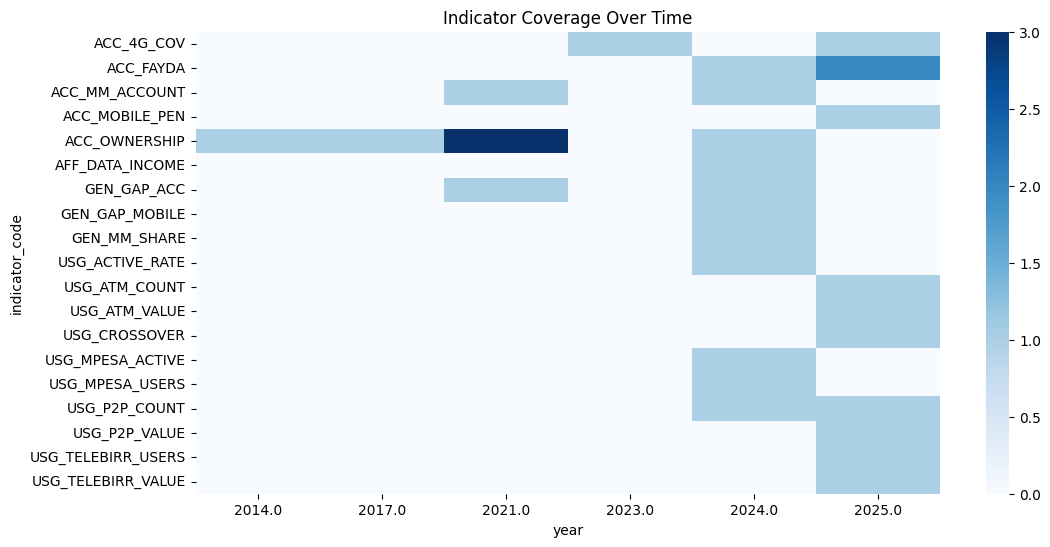

In [6]:


# Ensure datetime conversion
df["observation_date"] = pd.to_datetime(df["observation_date"], errors="coerce")

# Filter observations
obs = df[df.record_type == "observation"].copy()
obs["year"] = obs["observation_date"].dt.year

# Coverage matrix
coverage = (
    obs.groupby(["indicator_code", "year"])
       .size()
       .unstack(fill_value=0)
)

# Plot heatmap
plt.figure(figsize=(12,6))
sns.heatmap(coverage, cmap="Blues")
plt.title("Indicator Coverage Over Time")
plt.show()


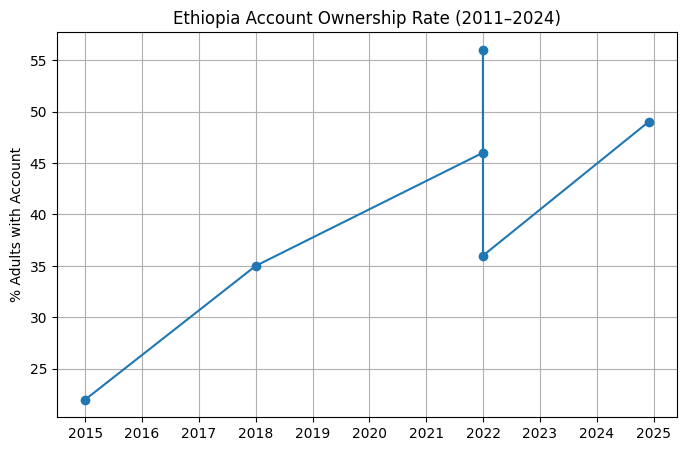

In [7]:
acc = obs[obs.indicator_code == "ACC_OWNERSHIP"]

plt.figure(figsize=(8,5))
plt.plot(acc.observation_date, acc.value_numeric, marker="o")
plt.title("Ethiopia Account Ownership Rate (2011–2024)")
plt.ylabel("% Adults with Account")
plt.grid(True)
plt.show()


In [8]:
acc = acc.sort_values("observation_date")
acc["growth_pp"] = acc.value_numeric.diff()
acc[["observation_date", "growth_pp"]]


,observation_date,growth_pp
0,2014-12-31,NaN
1,2017-12-31,13.0
2,2021-12-31,11.0
3,2021-12-31,10.0
4,2021-12-31,-20.0
5,2024-11-29,13.0


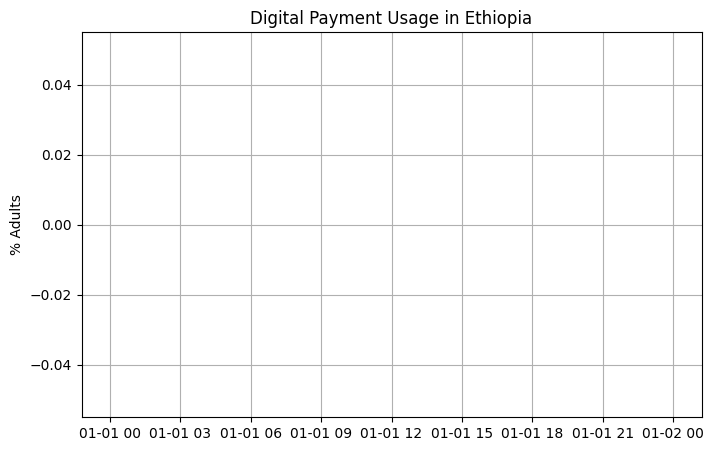

In [9]:
dp = obs[obs.indicator_code == "USG_DIGITAL_PAYMENT"]

plt.figure(figsize=(8,5))
plt.plot(dp.observation_date, dp.value_numeric, marker="o", color="green")
plt.title("Digital Payment Usage in Ethiopia")
plt.ylabel("% Adults")
plt.grid(True)
plt.show()


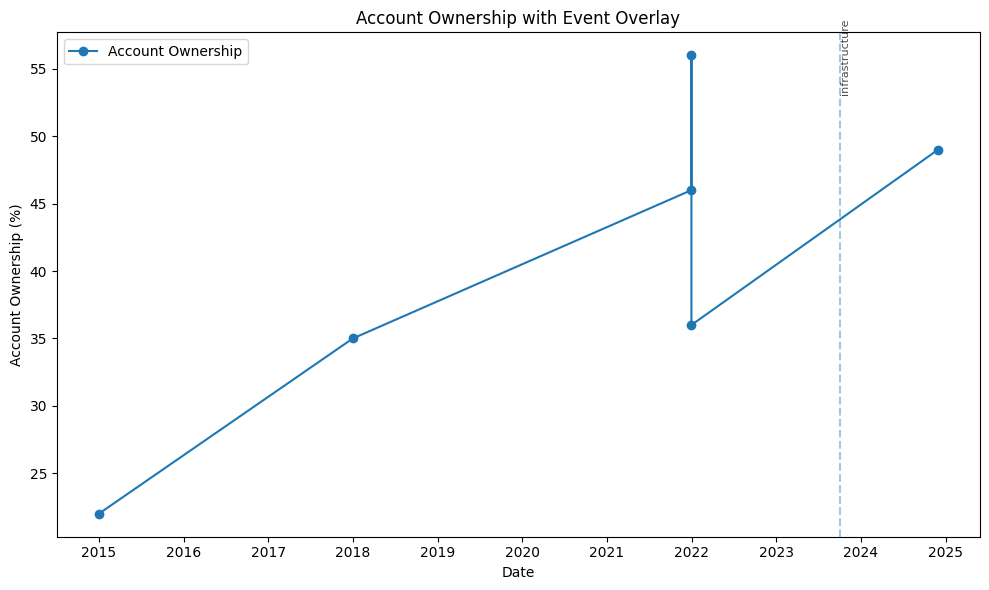

In [11]:

# Ensure datetime conversion for observation_date
df["observation_date"] = pd.to_datetime(df["observation_date"], errors="coerce")

# Filter account ownership observations
acc = df[(df["record_type"] == "observation") & (df["indicator_code"] == "ACC_OWNERSHIP")].copy()

# Convert event_date to datetime and drop NaT values
events = df[df["record_type"] == "event"].copy()
events["event_date"] = pd.to_datetime(events["event_date"], errors="coerce")
events_clean = events.dropna(subset=["event_date"])

# Plot account ownership trajectory
plt.figure(figsize=(10,6))
plt.plot(acc["observation_date"], acc["value_numeric"], marker="o", label="Account Ownership")

# Overlay events as vertical lines
for _, e in events_clean.iterrows():
    plt.axvline(e["event_date"], linestyle="--", alpha=0.4)
    # Optional: add labels for event categories
    plt.text(e["event_date"], acc["value_numeric"].max()*0.95, e["category"],
             rotation=90, fontsize=8, alpha=0.7)

plt.title("Account Ownership with Event Overlay")
plt.xlabel("Date")
plt.ylabel("Account Ownership (%)")
plt.legend()
plt.tight_layout()
plt.show()


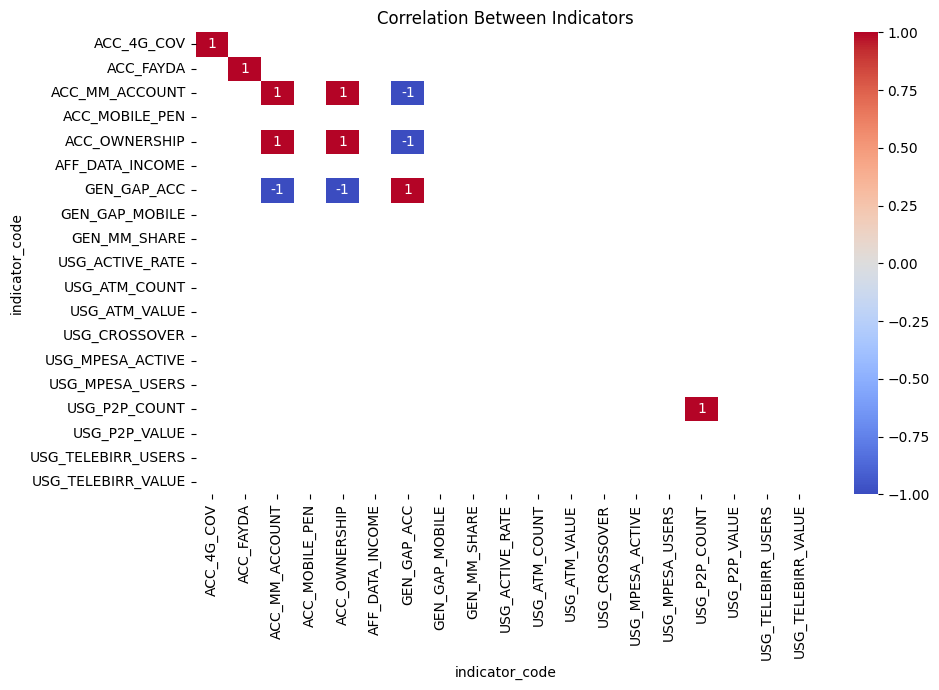

In [12]:
pivot = obs.pivot_table(
    index="observation_date",
    columns="indicator_code",
    values="value_numeric"
)

corr = pivot.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Between Indicators")
plt.show()
